[-0.005  0.     0.005  0.01   0.015  0.02   0.025  0.03   0.035  0.04
  0.045]


/tmp/ipykernel_31694/1421314931.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"{tick:.3f}" for tick in ticks])


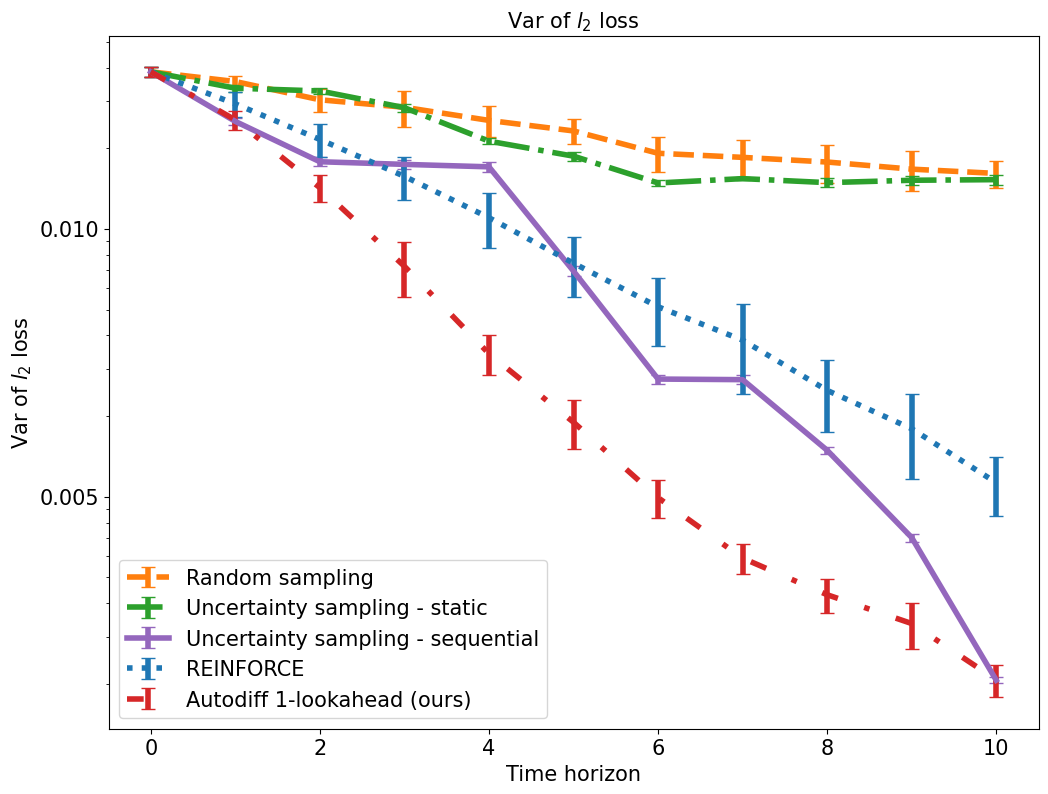

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7]


/tmp/ipykernel_31694/1421314931.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"{tick:.3f}" for tick in ticks])


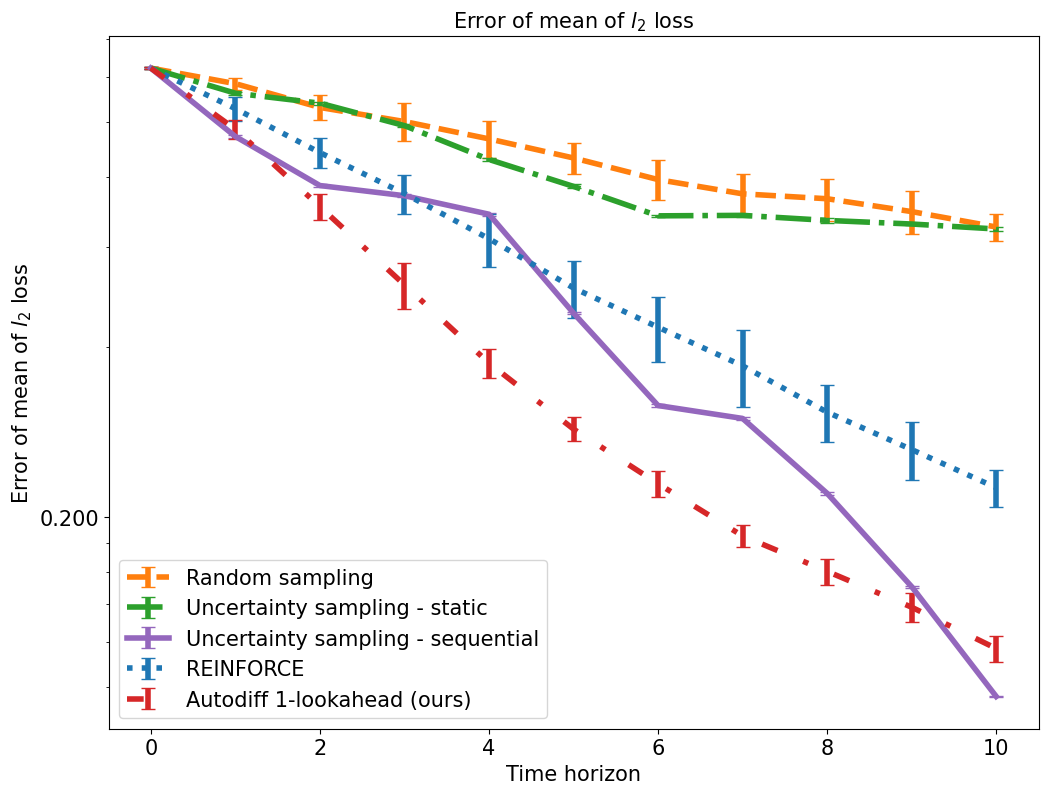

[0.005 0.006 0.007 0.008 0.009 0.01  0.011]


/tmp/ipykernel_31694/1421314931.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"{tick:.3f}" for tick in ticks])


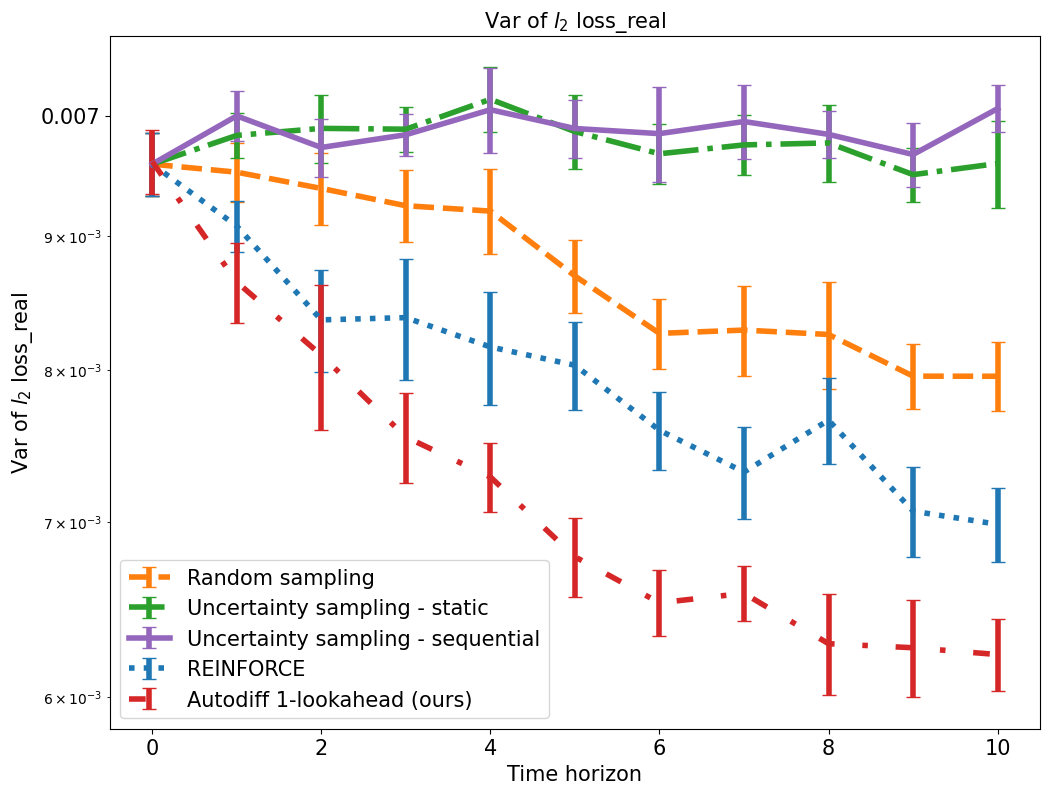

[0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9  ]


/tmp/ipykernel_31694/1421314931.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"{tick:.3f}" for tick in ticks])


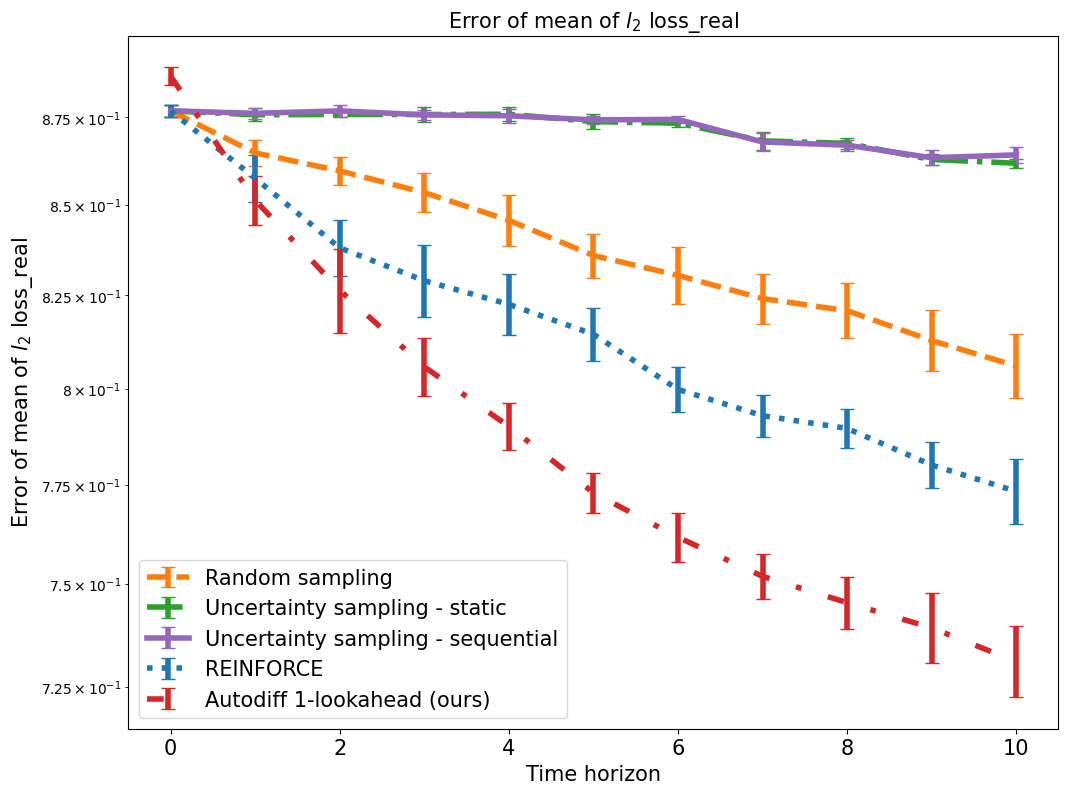

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#%config InlineBackend.figure_format = 'svg'

def good_index(Str):
    if 'MIN' in Str or 'MAX' in Str:
        return False
    else:
        return True
    
total_horizon, n_seed = 11, 10
fontsize = 15
line_styles = [':', '--', '-.', (0, (3, 5, 1, 5)), '-'] #, (, (3, 5, 1, 5))]  # Custom dash pattern
keys_all_dict = {'random':'Random sampling','uncertainty':'Uncertainty sampling - static', 'greedy-batch-uncertainty':'Uncertainty sampling - sequential',
 'policy_gradient':'REINFORCE','pipeline':'Autodiff 1-lookahead (ours)'}
method_name = ['active', 'pipeline','policy_gradient']
plotting_var_list = ['Var of $l_2$ loss', 'Error of mean of $l_2$ loss']


if_real_flag = 0
fontsize_legend = 15

for if_real_flag in [0,1]:
    if if_real_flag == 0:
        directory = './result_0519/'
        true_l2_loss = 0.004542
        file_name = [['active_learning_var.csv', 'pipeline_var.csv', 'pg_var.csv'],
                    ['active_learning_l2_loss.csv', 'pipeline_l2_loss.csv', 'pg_l2_loss.csv']
                    ]

        dict_name = ['dictionary_active_learning.csv']
    else:
        directory = './result_0519_real/'
        true_l2_loss = 0.048
        file_name = [['active_learning_var_real.csv', 'real_data_var_adaptive.csv', 'pg_var_real_clean.csv'],
                    ['active_learning_l2_loss_real.csv', 'real_data_mean_adaptive.csv', 'pg_l2_real_clean.csv']
                    ]

        dict_name = ['dictionary_active_learning_real.csv']

    for j in range(2):
        plotting_var = plotting_var_list[j]
        if if_real_flag == 1:
            plotting_var = plotting_var + '_real'
        for i in range(3):
            df_tmp = pd.read_csv(directory + file_name[j][i])
            if if_real_flag == 1 and i == 2:
                del df_tmp['Unnamed: 0']
            else:
                del df_tmp['Step']

            df_tmp = df_tmp.transpose()
            df_tmp['sweep_id'] = df_tmp.index



            if i == 0:
                dict_val = pd.read_csv(directory + dict_name[i])
                key_list = list(dict_val['Name'])

                if j == 0:
                    key_list = [_ + ' - var_square_loss_track' for _ in key_list]
                else:
                    key_list = [_ + ' - l2_loss_track' for _ in key_list]

                dictionary = dict(zip(key_list, list(dict_val['algo'])))
                df_tmp = df_tmp[df_tmp['sweep_id'].isin(list(dictionary.keys()))]
                df_tmp['sweep_id'].replace(dictionary, inplace=True)
            else:

                df_tmp['sweep_id_good'] = df_tmp['sweep_id'].apply(good_index)
                df_tmp = df_tmp[df_tmp['sweep_id_good'] == True]
                df_tmp['sweep_id'] = method_name[i]
                del df_tmp['sweep_id_good']



            if i == 0:
                df_all = df_tmp
            else:
                df_all = pd.concat([df_all, df_tmp], axis = 0)


        keys_all_old = list(set(df_all['sweep_id']))
        new_order_indices = [1, 2, 4,0, 3]
        G=[1,2,4,0,3]

        # Rearrange using list comprehension
        keys_all = [keys_all_old[i] for i in new_order_indices]
        #print(keys_all)
        All_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        All_colors = [All_colors[i] for i in new_order_indices]
        
        x_axis = list(range(total_horizon))
        plt.figure(figsize=(12, 9))  # Adjust width and height as needed

        for c,g,key in zip(All_colors,G,keys_all):
            #print(g)
            #print(key)
            res = []
            for i in range(n_seed):
                my_list = list(df_all[df_all['sweep_id'] == key].iloc[i])
                my_list = [x for x in my_list if not pd.isna(x)][:-1]
                if j != 0: #l2 loss
                    my_list = [np.abs(x - true_l2_loss) for x in my_list]
                res.append(my_list)


            mean_list = np.mean(res, axis = 0)
            std_list = np.std(res, axis = 0) * 1.96/np.sqrt(n_seed)
            plt.errorbar(x_axis, mean_list, yerr = std_list, capsize=5, color =c, label = keys_all_dict[key],linewidth = 4, linestyle = line_styles[g])

        
        plt.xlabel('Time horizon', fontsize = fontsize)
        plt.xticks(fontsize = fontsize)
        plt.ylabel(plotting_var, fontsize = fontsize)
        plt.yticks(fontsize = fontsize)
        ticks = plt.gca().get_yticks()
        print(ticks)
        plt.yscale('log')
        
        #current_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        #print(current_cycle)
        # Set custom y-tick labels
        plt.gca().set_yticklabels([f"{tick:.3f}" for tick in ticks])
        plt.title(plotting_var, fontsize = fontsize)
        plt.legend(fontsize = fontsize_legend)
        if if_real_flag == 0:
            plt.savefig(directory + plotting_var + '.pdf')
        else:
            plt.savefig(directory + plotting_var + '_real.pdf')

        plt.show()
    

In [16]:
#clean atom

var = 'l2'
for var in ['l2','var']:
    df_1 = pd.read_csv(directory + 'atom-1-' + var + '.csv')
    df_2 = pd.read_csv(directory + 'atom-2-' + var + '.csv')  
    df_0 = pd.read_csv(directory + 'real_data_pg_' + var + '.csv')

    def good_index_atom(Str):
        if 'atomic-sweep-1' in Str:
            return False
        else:
            return True

    df_0 = df_0.transpose()
    df_0['sweep_id'] = df_0.index
    df_0['sweep_good'] = df_0['sweep_id'].apply(good_index_atom)
    df_0 = df_0[df_0['sweep_good'] == True]
    df_0 = df_0.iloc[1:]
    df_1 = df_1.transpose()
    df_1 = df_1.iloc[1:]
    df_2 = df_2.transpose()
    df_2 = df_2.iloc[1:]
    df_clean = pd.concat([df_0,df_1,df_2], axis = 0)
    del df_clean['sweep_good']
    del df_clean['sweep_id']
    df_clean = df_clean.transpose()
    df_clean.to_csv(directory +'pg_'+ var + '_real_clean.csv')